# Chess Dataset Clustering Analysis

## 1. Introduction
### Objective:
The goal of this project is to explore clustering techniques on the Lichess chess dataset, which includes various features such as player ratings, game moves, and opening strategies. We aim to use K-Means clustering to group games based on specific features, evaluate the results using different metrics, and explore other clustering algorithms such as DBSCAN.

## 2. Data Preprocessing

- Encodes categorical variables (opening_eco, opening_name, and winner).
- Selects relevant features and filters out games with fewer than 20 moves.

In [4]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
data_path = '../data/raw_data/chess/games.csv'  # adjust the path as necessary
df = pd.read_csv(data_path)

# Data cleaning: Filter games with >19 moves, remove unnecessary columns
df = df[df['turns'] > 19]
df = df[['turns', 'white_rating', 'black_rating', 'opening_eco', 'opening_name', 'winner']]

# Encoding categorical variables
encoder_eco = LabelEncoder()
df['opening_eco_encoded'] = encoder_eco.fit_transform(df['opening_eco'])

# Fill missing values in opening_name
df.fillna({'opening_name':'Unknown'}, inplace=True)
encoder_name = LabelEncoder()
df['opening_name_encoded'] = encoder_name.fit_transform(df['opening_name'])

# Encode winner
df['winner_encoded'] = df['winner'].map({'white': 0, 'black': 1, 'draw': 2})

df.head()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


turns  white_rating  black_rating opening_eco  \
2     61          1496          1500         C20   
3     61          1439          1454         D02   
4     95          1523          1469         C41   
6     33          1520          1423         D00   
8     66          1439          1392         C50   

                                 opening_name winner  opening_eco_encoded  \
2       King's Pawn Game: Leonardis Variation  white                  171   
3      Queen's Pawn Game: Zukertort Variation  white                  241   
4                            Philidor Defense  white                  192   
6  Blackmar-Diemer Gambit: Pietrowsky Defense  white                  239   
8       Italian Game: Schilling-Kostic Gambit  black                  201   

   opening_name_encoded  winner_encoded  
2                   643               0  
3                   979               0  
4                   775               0  
6                    89               0  
8                   497               1

## 3. K-Means Clustering with Varying Cluster Numbers

- Performs the Elbow Method to find the optimal number of clusters.
- Visualizes the elbow curve to identify the best k.


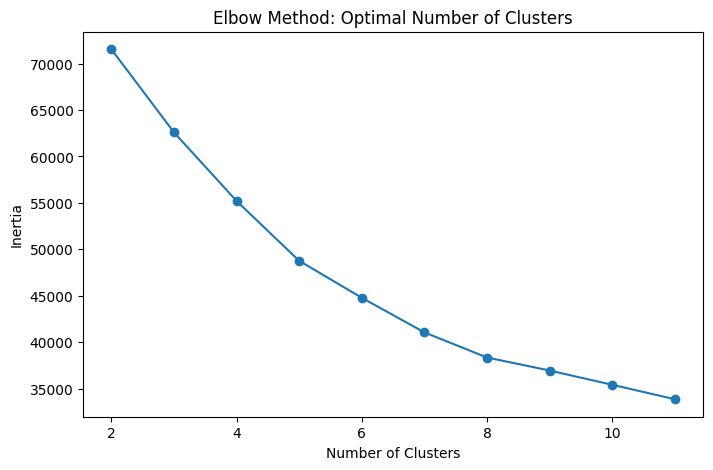

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize data before clustering
features = ['turns', 'white_rating', 'black_rating', 'opening_eco_encoded', 'opening_name_encoded']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to find optimal number of clusters
inertia = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 12), inertia, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


## 4. Clustering Evaluation Metrics

- Calculates and plots Silhouette Scores and Davies-Bouldin Index for different cluster numbers.
- Helps evaluate the quality of the clusters based on these metrics.


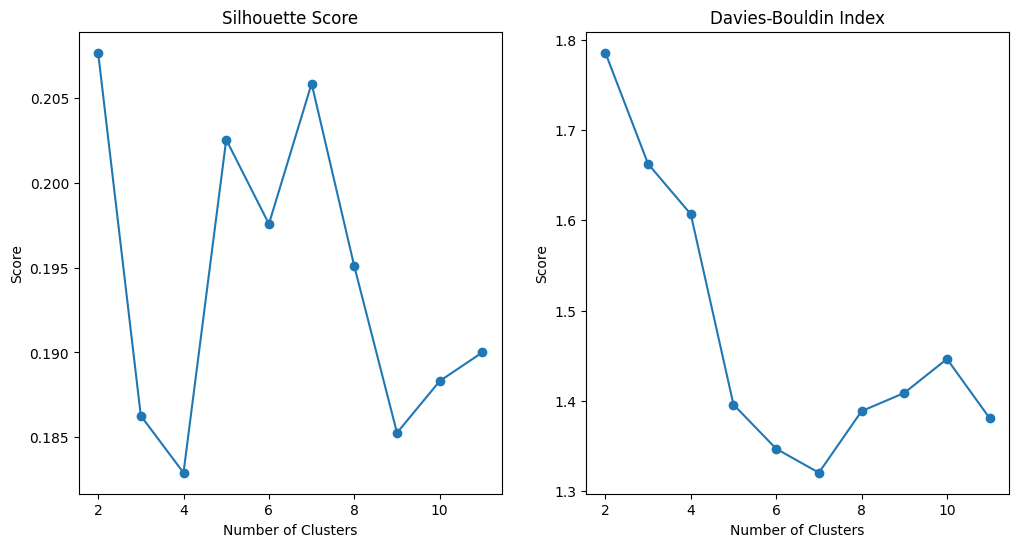

In [7]:
# Silhouette Score and Davies-Bouldin Index for different k values
sil_scores = []
db_scores = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    sil_scores.append(silhouette_score(X_scaled, cluster_labels))
    db_scores.append(davies_bouldin_score(X_scaled, cluster_labels))

# Plot the Silhouette and Davies-Bouldin scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 12), sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(range(2, 12), db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()


## 5. PCA and K-Means Clustering Visualization

- Applies PCA to reduce the data to 2D and 3D, and visualizes the clusters found by K-Means.


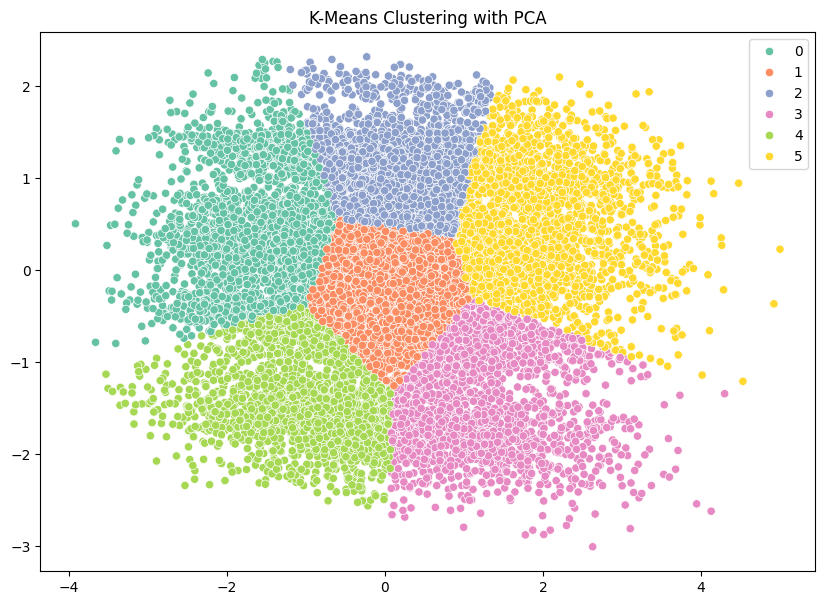

Silhouette Score: 0.34286629717523165
Davies-Bouldin Index: 0.847032323370104


In [39]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Perform K-Means with the optimal k 
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2')
plt.title('K-Means Clustering with PCA')
plt.show()

# Calculate Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(X_pca, clusters)
db_index = davies_bouldin_score(X_pca, clusters)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {db_index}')

In [68]:
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from plotly.offline import iplot

# Perform PCA to reduce to 3 principal components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)  # X_scaled is your standardized data

# Perform K-Means Clustering on the 3D PCA data
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Create a 3D Scatter plot
trace = go.Scatter3d(
    x=X_pca[:, 0],  # Principal Component 1
    y=X_pca[:, 1],  # Principal Component 2
    z=X_pca[:, 2],  # Principal Component 3
    mode='markers',
    marker=dict(
        size=5,
        color=clusters,  # Color by cluster
        colorscale='Viridis',  # Color scale
        opacity=0.8
    )
)

# Define layout
layout = go.Layout(
    title="3D Clustering Visualization",
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Plot the figure
iplot(fig)

# Calculate Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(X_pca, clusters)
db_index = davies_bouldin_score(X_pca, clusters)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {db_index}')


Silhouette Score: 0.24611400396612806
Davies-Bouldin Index: 1.1124098320697817


## 6. DBSCAN Clustering

- Apply DBSCAN with varying parameters (eps, min_samples), and evaluate the clustering performance.

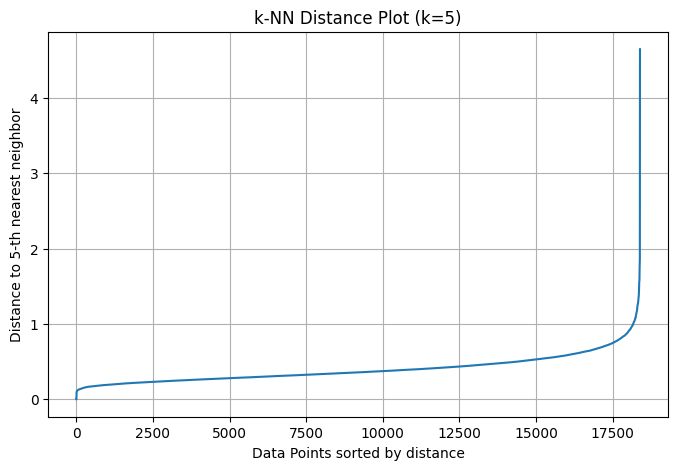

Best DBSCAN parameters: eps=1.0, min_samples=5
eps=0.1, min_samples=5, Silhouette Score=-0.40898892043102225, Davies-Bouldin Index=1.7560634578224095
eps=0.1, min_samples=6, Silhouette Score=0.16971562790479566, Davies-Bouldin Index=0.6747629695698918
eps=0.2, min_samples=5, Silhouette Score=-0.591452467765276, Davies-Bouldin Index=1.537689847341301
eps=0.2, min_samples=6, Silhouette Score=-0.5888859269788497, Davies-Bouldin Index=1.5773616551415794
eps=0.2, min_samples=7, Silhouette Score=-0.56448545259149, Davies-Bouldin Index=1.6491568414459687
eps=0.2, min_samples=8, Silhouette Score=-0.5507009617012358, Davies-Bouldin Index=1.7478352151308634
eps=0.2, min_samples=9, Silhouette Score=-0.5150606381322005, Davies-Bouldin Index=1.7897013863273006
eps=0.2, min_samples=10, Silhouette Score=-0.4719895127078431, Davies-Bouldin Index=1.744332681402571
eps=0.2, min_samples=11, Silhouette Score=-0.44957715699806927, Davies-Bouldin Index=1.7556992059244727
eps=0.2, min_samples=12, Silhouette 

In [47]:
# Step 1: Compute the k-Nearest Neighbors distance
def compute_knn_distances(X_scaled, n_neighbors):
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_scaled)
    distances, _ = knn.kneighbors(X_scaled)
    
    # Sort the distances to the n-th nearest neighbor in ascending order
    sorted_distances = np.sort(distances[:, n_neighbors - 1])
    return sorted_distances

# Step 2: Plot the k-NN distance plot to find a suitable eps
def plot_knn_distance(X_scaled, n_neighbors=5):
    sorted_distances = compute_knn_distances(X_scaled, n_neighbors)
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_distances)
    plt.title(f'k-NN Distance Plot (k={n_neighbors})')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'Distance to {n_neighbors}-th nearest neighbor')
    plt.grid(True)
    plt.show()

# Step 3: Automatic selection of eps and min_samples based on Silhouette Score or Davies-Bouldin Index
def dbscan_auto_select(X_scaled, eps_values, min_samples_range):
    best_silhouette = -1  # Store the best silhouette score
    best_params = {}       # Store the best params for DBSCAN
    results = []

    for eps in eps_values:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_scaled)

            # Ignore cases where all points are classified as noise
            if len(np.unique(clusters)) > 1:
                silhouette = silhouette_score(X_scaled, clusters)
                db_index = davies_bouldin_score(X_scaled, clusters)

                results.append((eps, min_samples, silhouette, db_index))

                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_params = {'eps': eps, 'min_samples': min_samples}
    
    return results, best_params

# Step 4: Plot the k-NN distance plot to find elbow point
plot_knn_distance(X_scaled, n_neighbors=5)

# Step 5: Automatically choose the best eps and min_samples values based on performance metrics
eps_values = np.linspace(0.1, 1.0, 10)  # Try a range of eps values from 0.1 to 1.0
min_samples_range = range(5, 16)        # Try min_samples between 5 and 15
results, best_params = dbscan_auto_select(X_scaled, eps_values, min_samples_range)

# Step 6: Print best DBSCAN configuration and results
print(f"Best DBSCAN parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")

# Step 7: Print the detailed results of the experiments
for result in results:
    eps, min_samples, silhouette, db_index = result
    # print(f"eps={eps}, min_samples={min_samples}, Silhouette Score={silhouette}, Davies-Bouldin Index={db_index}")


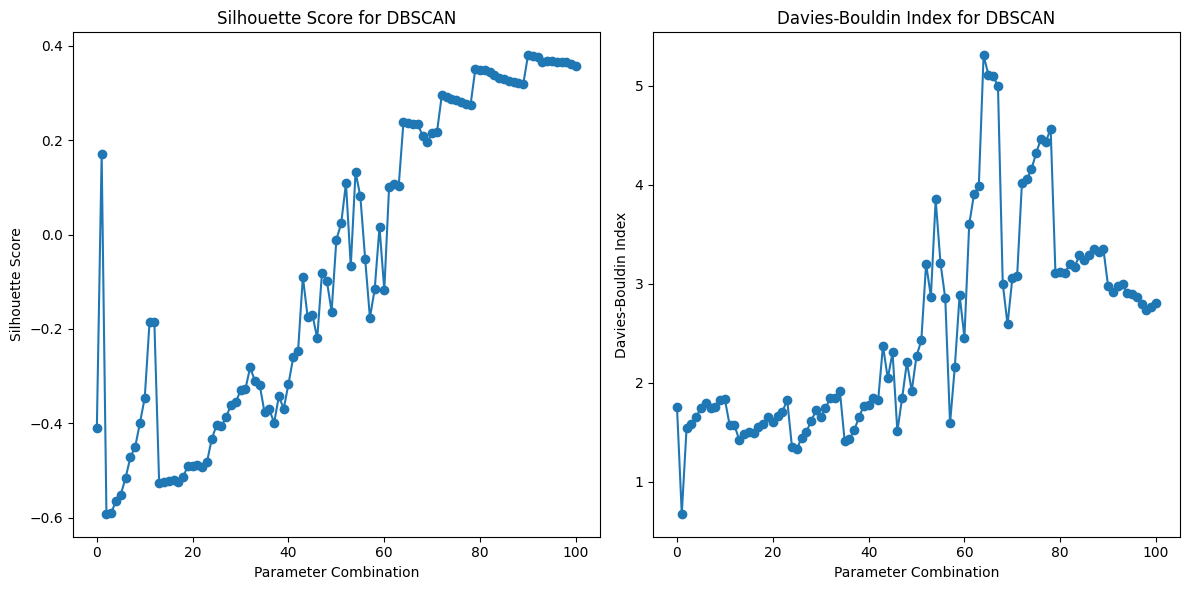

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

# Define the range for eps and min_samples
eps_values = np.linspace(0.1, 1.0, 10)  # Testing a range of eps values
min_samples_values = range(5, 16)       # Testing min_samples from 5 to 15

# Lists to store the scores for each parameter combination
sil_scores = []
db_scores = []

# Loop through different eps and min_samples values
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)
        
        # Ignore cases where all points are classified as noise
        if len(np.unique(cluster_labels)) > 1:
            sil_scores.append(silhouette_score(X_scaled, cluster_labels))
            db_scores.append(davies_bouldin_score(X_scaled, cluster_labels))

# Plot the Silhouette and Davies-Bouldin scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(sil_scores)), sil_scores, marker='o')
plt.title('Silhouette Score for DBSCAN')
plt.xlabel('Parameter Combination')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(range(len(db_scores)), db_scores, marker='o')
plt.title('Davies-Bouldin Index for DBSCAN')
plt.xlabel('Parameter Combination')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()


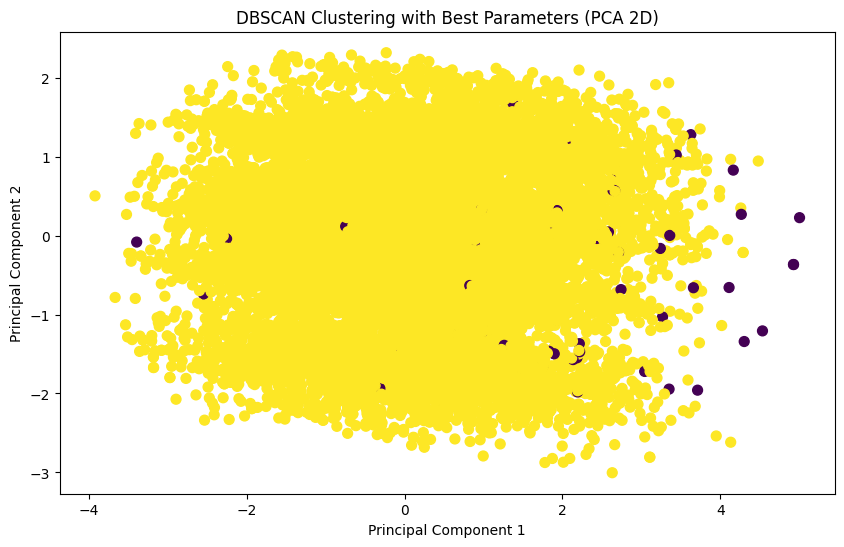

DBSCAN Silhouette Score: 0.37963321435524416
DBSCAN Davies-Bouldin Index: 2.9708091175845484


In [66]:
# Step 5: Perform DBSCAN with the best parameters
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_scaled)

# Calculate metrics for DBSCAN
sil_dbscan = silhouette_score(X_scaled, dbscan_clusters)
db_dbscan = davies_bouldin_score(X_scaled, dbscan_clusters)

# Step 6: Visualize the clusters using PCA in 2D or 3D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_clusters, cmap='viridis', s=50)
plt.title('DBSCAN Clustering with Best Parameters (PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print(f"DBSCAN Silhouette Score: {sil_dbscan}")
print(f"DBSCAN Davies-Bouldin Index: {db_dbscan}")

In [65]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 3D Visualization Function
def plotly_scatter3d(data, clusters, feat1, feat2, feat3, title):
    trace = go.Scatter3d(
        x=data[feat1],
        y=data[feat2],
        z=data[feat3],
        mode='markers',
        marker=dict(
            size=5,
            color=clusters,
            colorscale='Viridis',
            opacity=0.8
        )
    )

    layout = go.Layout(
        title=title,
        margin=dict(l=0, r=0, b=0, t=30),
        scene=dict(
            xaxis_title=feat1,
            yaxis_title=feat2,
            zaxis_title=feat3
        )
    )

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

# Apply PCA to reduce dimensions to 3 for 3D plotting
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

# DBSCAN with the best parameters 
dbscan_3d = DBSCAN(eps=1, min_samples=5)
dbscan_clusters_3d = dbscan_3d.fit_predict(X_scaled)

# Plot the 3D visualization
plotly_scatter3d(pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3']),
                 dbscan_clusters_3d, 'PC1', 'PC2', 'PC3', 'DBSCAN Clustering 3D View with PCA')

# Calculate and print DBSCAN metrics for the 3D visualization
sil_dbscan_3d = silhouette_score(X_pca_3d, dbscan_clusters_3d)
db_dbscan_3d = davies_bouldin_score(X_pca_3d, dbscan_clusters_3d)

print(f"DBSCAN 3D Silhouette Score: {sil_dbscan_3d}")
print(f"DBSCAN 3D Davies-Bouldin Index: {db_dbscan_3d}")


DBSCAN 3D Silhouette Score: 0.28196016736223145
DBSCAN 3D Davies-Bouldin Index: 2.6204828455304985


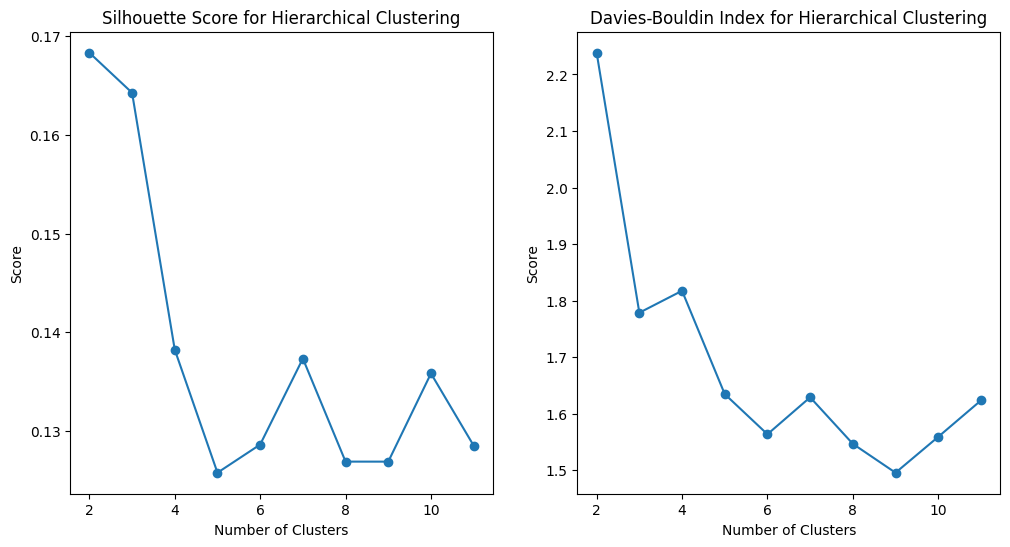

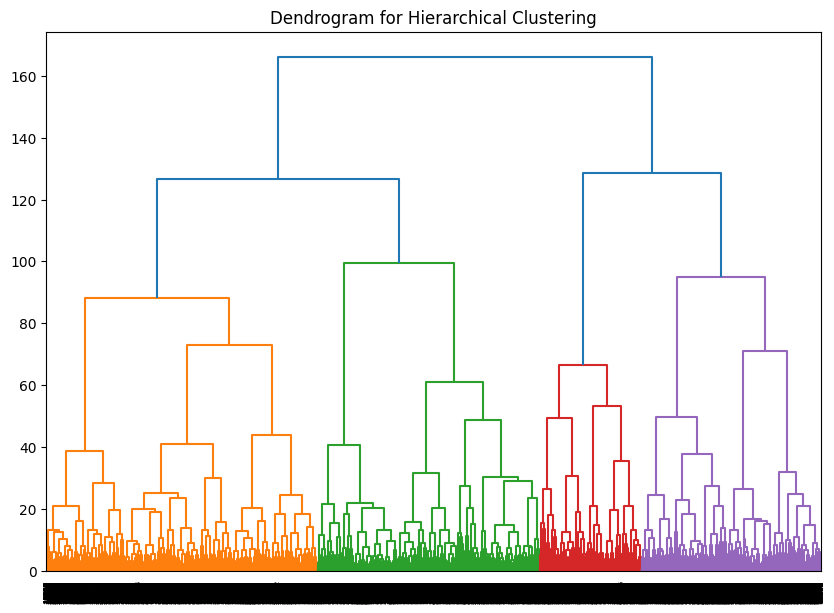

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Step 1: Perform Agglomerative Clustering
def hierarchical_clustering(X_scaled, num_clusters, linkage_method='ward'):
    # Perform Agglomerative Clustering
    hc = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage_method)
    cluster_labels = hc.fit_predict(X_scaled)
    return cluster_labels

# Step 2: Evaluate the clustering using Silhouette Score and Davies-Bouldin Index
def evaluate_clustering(X_scaled, cluster_labels):
    sil_score = silhouette_score(X_scaled, cluster_labels)
    db_index = davies_bouldin_score(X_scaled, cluster_labels)
    return sil_score, db_index

# Step 3: Run experiments with different numbers of clusters
num_clusters_range = range(2, 12)
sil_scores = []
db_scores = []

for k in num_clusters_range:
    cluster_labels = hierarchical_clustering(X_scaled, k)
    sil_score, db_score = evaluate_clustering(X_scaled, cluster_labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(num_clusters_range, sil_scores, marker='o')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(num_clusters_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

# Step 5: Visualize Dendrogram (for linkage='ward', 'complete', or 'average')
plt.figure(figsize=(10, 7))
Z = linkage(X_scaled, method='ward')  # You can try 'complete', 'average', etc.
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()


## 7. Deep Dive into the Clusters

- Provides insights into each cluster, including average player ratings and game length.
- Interprets clusters in terms of chess strategies and player behavior.

In [13]:
# Analyze clusters (e.g., by rating, opening)
df['cluster'] = clusters

# Group by clusters and analyze
cluster_analysis = df.groupby('cluster').agg({
    'turns': 'mean',
    'white_rating': 'mean',
    'black_rating': 'mean',
    'winner_encoded': 'mean'
}).reset_index()

print(cluster_analysis)


   cluster      turns  white_rating  black_rating  winner_encoded
0        0  55.555718   1312.191210   1305.191627        0.528015
1        1  75.371912   1959.372190   1960.659728        0.601998
2        2  61.685517   1580.875084   1570.730925        0.525658
3        3  71.390268   1679.300811   1678.424920        0.588842


## 8. Conclusion

- Summarizes the insights gained from clustering.
- Highlights how clustering can be used to identify trends in chess games based on player ratings, openings, and outcomes.
